In [50]:
# import libraries
import numpy as np
import matplotlib.pyplot as plt

from KalmanFilters import KalmanFilter, FixLagSmoother
from helper_functions import gen_data

# set plot parameters
plt.rcParams.update({'font.size': 16})
plt.rcParams['text.usetex'] = True

## Define Kalman filter and fix-lag smoother classes

In [53]:
# define parameters
N = 10 # lag window size
A = np.array([[1, 1], [0, 1]]) # train matrix
Q = np.array([[0.25, 0.5], [0.5, 1]]) * 0.1**2 # transition covariance matrix
C = np.array([[1, 0]]) # observation matrix
R = np.array([[4]]) # observation covariance matrix

x = np.array([1, -1]) # initial state
P = np.array([[2**2, 0],
                          [0, 1.5**2]]) # initial state covariance matrix

## Generate data

In [54]:
# generate data
n = 50
z, t = gen_data(n, R)

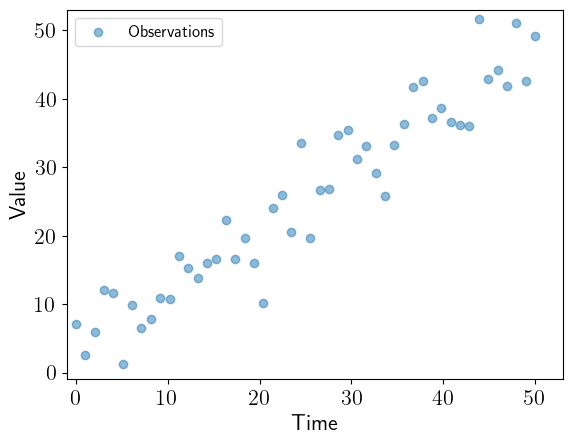

In [55]:
# plot data
plt.scatter(t, z, label='Observations', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(-1, n+3)
plt.ylim(-1, n+3)
plt.legend(loc= 'upper left', fontsize=12)
plt.savefig('out/' + 'Observations.png', dpi=300, bbox_inches='tight')


## Fix-lag smoother

In [56]:
# create smoother object
lag_smoother = FixLagSmoother(N, A, Q, C, R, x, P)

In [57]:
# smooth data
for obs in z:
    lag_smoother.smooth(obs)

In [58]:
xlag_smooth = np.array(lag_smoother.x_smooth)[:, 0]
Plag_smooth = np.array(lag_smoother.Sigma_smooth)[:, 0, 0]

## Kalman filter

In [59]:
# create Kalman filter object
kf = KalmanFilter(A, Q, C, R, x, P)

In [60]:
# filter data
for obs in z:
    kf.filter(obs)

In [61]:
x_filt = np.array(kf.x_filt)[:, 0]
P_filt = np.array(kf.P_filt)[:, 0, 0]

## RTS smoother

In [62]:
# create RTS smoother object
kf.smooth()

In [63]:
# smooth data
x_smooth = np.array(kf.x_smooth)[:, 0]
P_smooth = np.array(kf.P_smooth)[:, 0, 0]

## Plot Results

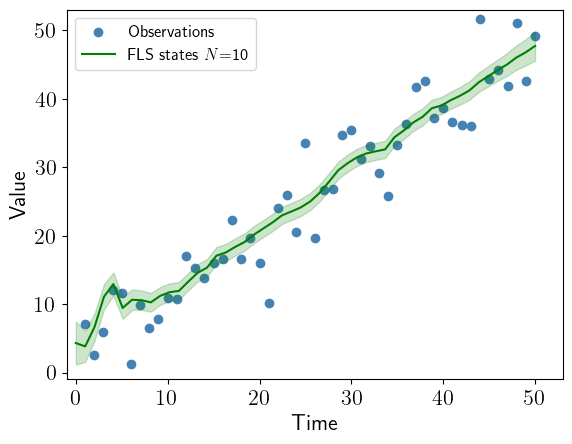

In [64]:
# plot data
plt.scatter(range(1,len(t)+1), z, label='Observations', color='steelblue')
plt.plot(t, xlag_smooth, label='FLS states $N$='+str(N), color='green')
plt.fill_between(t, xlag_smooth - 2*np.sqrt(Plag_smooth), xlag_smooth + 2*np.sqrt(Plag_smooth), color='g', alpha=0.2)
# plt.plot(range(len(t)+1), x_filt, label='KF states', linestyle='--', color='red')
# plt.fill_between(range(len(t)+1), x_filt - 2*np.sqrt(P_filt), x_filt + 2*np.sqrt(P_filt), color='red', alpha=0.2)
# plt.plot(range(len(t)+1), x_smooth, label='RTS states', linestyle='--', color='orange')
# plt.fill_between(range(len(t)+1), x_smooth - 2*np.sqrt(P_smooth), x_smooth + 2*np.sqrt(P_smooth), color='orange', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(-1, n+3)
plt.ylim(-1, n+3)
# location of legend is outside the plot
plt.legend(loc='upper left', fontsize=12)
plt.savefig('out/' + 'Results.png', dpi=300, bbox_inches='tight')

In [65]:
# get MSE of smoothed data
mse_smooth = np.mean((x_smooth[1:] - t)**2)
print(f'MSE of smoothed data: {round(mse_smooth,4)}')

# get MSE of filtered data
mse_filt = np.mean((x_filt[1:] - t)**2)
print(f'MSE of filtered data: {round(mse_filt, 4)}')

# get MSE of lag smoothed data
mse_lag_smooth = np.mean((xlag_smooth - t)**2)
print(f'MSE of lag smoothed data: {round(mse_lag_smooth, 4)}')

MSE of smoothed data: 2.931
MSE of filtered data: 4.9735
MSE of lag smoothed data: 6.0051


## Experiment with N

In [66]:
# iterate over different lag window sizes and get MSE
MSE = []
for N in range(1, 30):
    lag_smoother = FixLagSmoother(N, A, Q, C, R, x, P)
    for obs in z:
        lag_smoother.smooth(obs)
    xlag_smooth = np.array(lag_smoother.x_smooth)[:, 0]
    mse_lag_smooth = np.mean((xlag_smooth - t)**2)
    MSE.append(mse_lag_smooth)

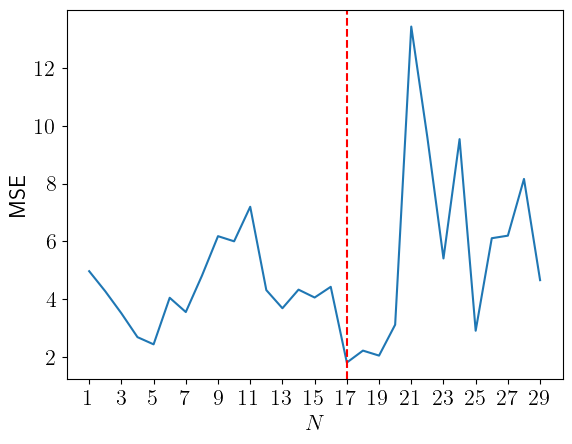

In [67]:
# plot MSE
plt.plot(range(1, 30), MSE)

 # N written as latex equation for x labek
plt.xlabel(r'${N}$')
plt.ylabel('MSE')
plt.xticks(range(1, 30, 2))

plt.axvline(np.argmin(MSE)+1, color='red', linestyle='--')
plt.savefig('out/' + 'N_optimal.png', dpi=300, bbox_inches='tight')

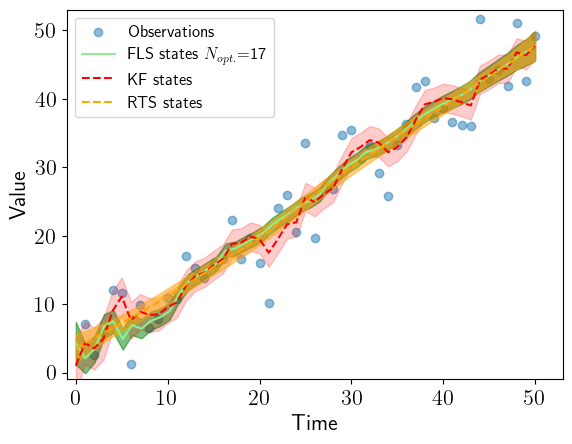

In [68]:
# get optimal N
optimal_N = np.argmin(MSE)+1

# aplly fix-lag smoother with optimal N
lag_smoother = FixLagSmoother(optimal_N, A, Q, C, R, x, P)
for obs in z:
    lag_smoother.smooth(obs)
xlag_smooth = np.array(lag_smoother.x_smooth)[:, 0]
Plag_smooth = np.array(lag_smoother.Sigma_smooth)[:, 0, 0]

# plot data
plt.scatter(range(1,len(t)+1), z, label='Observations', alpha=0.5)
plt.plot(t, xlag_smooth, label='FLS states $N_{opt.}$='+str(optimal_N), color='lightgreen')
plt.fill_between(t, xlag_smooth - 2*np.sqrt(Plag_smooth), xlag_smooth + 2*np.sqrt(Plag_smooth), color='green', alpha=0.5)
plt.plot(range(len(t)+1), x_filt, label='KF states', linestyle='--', color='red')
plt.fill_between(range(len(t)+1), x_filt - 2*np.sqrt(P_filt), x_filt + 2*np.sqrt(P_filt), color='red', alpha=0.2)
plt.plot(range(len(t)+1), x_smooth, label='RTS states', linestyle='--', color='orange')
plt.fill_between(range(len(t)+1), x_smooth - 2*np.sqrt(P_smooth), x_smooth + 2*np.sqrt(P_smooth), color='orange', alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(-1, n+3)
plt.ylim(-1, n+3)
# location of legend is outside the plot
plt.legend(loc='upper left', fontsize=12)
plt.savefig('out/' + 'Optimal_smoothing.png', dpi=300, bbox_inches='tight')

In [69]:
# get MSE of optimal smoothed data
mse_smooth = np.mean((xlag_smooth - t)**2)
print(f'MSE of optimal smoothed data: {round(mse_smooth, 4)}')

MSE of optimal smoothed data: 1.8187


## Experiment with different observation noise and N

In [70]:
# generate multiple datasets with different observation noise
Z = []
# generate data
np.random.seed(0)

R = np.array([0.1, 0.5, 1, 2, 5, 10])
n = 100
t = np.linspace(0, n, n)

for r in R:
    Z.append(t + np.random.normal(0, r, n)) 

(-1.0, 101.0)

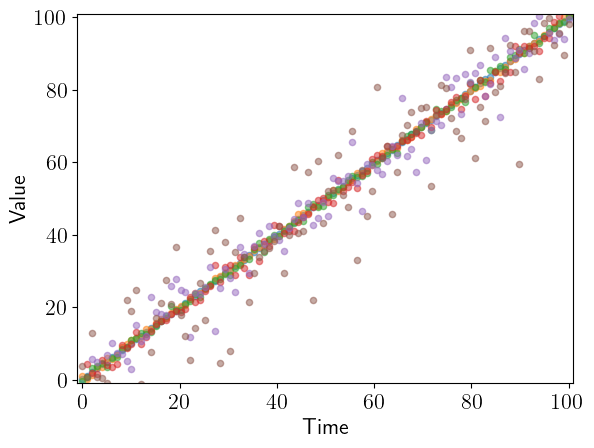

In [71]:
# plot data
for z in Z:
    plt.scatter(t, z, label='Observations', alpha=0.5, s=20)
plt.xlabel('Time')
plt.ylabel('Value')
plt.xlim(-1, n+1)
plt.ylim(-1, n+1)

In [72]:
# run fixed lag smoother for different observation noise and N 
# and collect optimal N for each dataset
optimal_Ns = []

for z, r in zip(Z, R):
    MSE = []
    for N in range(1, 20):
        
        lag_smoother = FixLagSmoother(N, A, Q, C, r, x, P)
        for obs in z:
            lag_smoother.smooth(obs)
            
        xlag_smooth = np.array(lag_smoother.x_smooth)[:, 0]
        mse_lag_smooth = np.mean((xlag_smooth - t)**2)
        MSE.append(mse_lag_smooth)
    optimal_N = np.argmin(MSE)+1
    optimal_Ns.append(optimal_N)

<>:3: SyntaxWarning: invalid escape sequence '\s'
<>:3: SyntaxWarning: invalid escape sequence '\s'
/var/folders/2n/rgg8qrjd2dv0zkx0bktfvk2h0000gn/T/ipykernel_24419/1390741214.py:3: SyntaxWarning: invalid escape sequence '\s'
  plt.xlabel('$$\sigma^2_{R}$$')


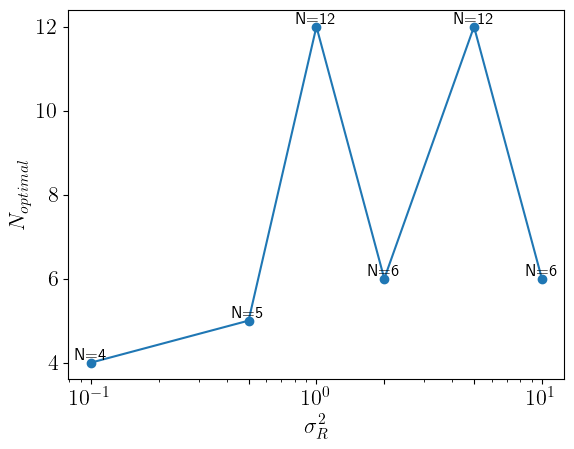

In [73]:
# plot optimal N for each value of observation noise
plt.plot(R, optimal_Ns, marker='o')
plt.xlabel('$$\sigma^2_{R}$$')
plt.ylabel('$$N_{optimal}$$')
plt.xscale('log')
plt.xticks(R)
for r, N in zip(R, optimal_Ns):
    plt.text(r, N, f'N={N}', fontsize=12, ha='center', va='bottom')
# plt.savefig('out/' + 'Optimal_N.png', dpi=300, bbox_inches='tight')